# Building a simple neural network

In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm

from data import cicids
from utils import utils

Check if GPU is active.

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cpu device


### Create the Fully Connected Feed Forward Neural Network

In [3]:
class NN(nn.Module):

    def __init__(self, num_features=47, hidden1_size=64, hidden2_size=64, num_classes=6):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(num_features, hidden1_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

### Create the DataLoader

In [4]:
# Get the datasets
train_data, val_data, test_data = cicids.get_dataset()

# How many instances have we got?
print('# instances in training set: ', len(train_data))
print('# instances in validation set: ', len(val_data))
print('# instances in testing set: ', len(test_data))

samples_weight = utils.get_samples_weight(train_data.labels['label'])
sampler = torch.utils.data.sampler.WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)

batch_size = 64

# Create the dataloaders - for training, validation and testing
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, sampler=sampler)
valid_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

# instances in training set:  1318783
# instances in validation set:  439595
# instances in testing set:  439595


### Instantiate the network, the loss function and the optimizer

In [5]:
# Our model
model = NN(47, 64, 64, 6)

# Out loss function
criterion = nn.CrossEntropyLoss()

# Our optimizer
learning_rate = 0.02
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# Epochs
num_epochs = 5

In [6]:
print(model)

NN(
  (fc1): Linear(in_features=47, out_features=64, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=64, out_features=6, bias=True)
)


### Train it

In [7]:
def train(net, optimizer, criterion, train_loader, valid_loader, num_epochs, device):
    """Train the network."""

    net.to(device)

    history = {
        'train': {
            'total': 0,
            'loss': [],
            'accuracy': [],
            'output_pred': [],
            'output_true': []
        },
        'validation': {
            'total': 0,
            'loss': [],
            'accuracy': [],
            'output_pred': [],
            'output_true': []
        }
    }
        
    for epoch in range(1, num_epochs+1):

        ########################
        ##     TRAIN LOOP     ##
        ########################
        net.train()

        train_loss = 0.0
        train_steps = 0
        train_total = 0
        train_correct = 0

        train_output_pred = []
        train_output_true = []

        print(f"Epoch {epoch}/{num_epochs}:")
        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()
            outputs = net(inputs.float())

            # forward + backward + optimize
            loss = criterion(outputs, labels.type(torch.LongTensor))
            loss.backward()
            optimizer.step()

            train_loss += loss.cpu().item()
            train_steps += 1

            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels.type(torch.LongTensor)).sum().item()

            train_output_pred += outputs.argmax(1).tolist()
            train_output_true += labels.tolist()


        ########################
        ##     VALID LOOP     ##
        ########################
        net.eval()

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        val_total = 0
        val_correct = 0

        val_output_pred = []
        val_output_true = []

        for inputs, labels in valid_loader:
            with torch.no_grad():
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs.float())

                loss = criterion(outputs, labels.type(torch.LongTensor))
                val_loss += loss.cpu().numpy()
                val_steps += 1

                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels.type(torch.LongTensor)).sum().item()

                val_output_pred += outputs.argmax(1).tolist()
                val_output_true += labels.tolist()

        history['train']['total'] = train_total
        history['train']['loss'].append(train_loss/train_steps)
        history['train']['accuracy'].append(train_correct/train_total)
        history['train']['output_pred'] = train_output_pred
        history['train']['output_true'] = train_output_true

        history['validation']['total'] = val_total
        history['validation']['loss'].append(val_loss/val_steps)
        history['validation']['accuracy'].append(val_correct/val_total)
        history['validation']['output_pred'] = val_output_pred
        history['validation']['output_true'] = val_output_true

        print(f'loss: {train_loss/train_steps} - acc: {train_correct/train_total} - val_loss: {val_loss/val_steps} - val_acc: {val_correct/val_total}\n')

    print("Finished Training")
    return history

In [8]:
history = train(model, optimizer, criterion, train_loader, valid_loader, num_epochs, device)

training_loss = history['train']['loss']
training_accuracy = history['train']['accuracy']
train_output_true = history['train']['output_true']
train_output_pred = history['train']['output_pred']

validation_loss = history['validation']['loss']
validation_accuracy = history['validation']['accuracy']
valid_output_true = history['validation']['output_true']
valid_output_pred = history['validation']['output_pred']

Epoch 1/5:


100%|████████████████████████████████████████████████████████████████████████████| 20606/20606 [07:37<00:00, 45.08it/s]


loss: 0.04850331745520527 - acc: 0.9865694356084359 - val_loss: 0.07519417352653963 - val_acc: 0.9695469693695333

Epoch 2/5:


100%|████████████████████████████████████████████████████████████████████████████| 20606/20606 [07:42<00:00, 44.53it/s]


loss: 0.025926392065272016 - acc: 0.992573455981765 - val_loss: 0.05596554008548933 - val_acc: 0.9766944573982871

Epoch 3/5:


100%|████████████████████████████████████████████████████████████████████████████| 20606/20606 [07:27<00:00, 46.07it/s]


loss: 0.02110529672330982 - acc: 0.9937836626647447 - val_loss: 0.05012783367171077 - val_acc: 0.9792104095815467

Epoch 4/5:


100%|████████████████████████████████████████████████████████████████████████████| 20606/20606 [07:25<00:00, 46.27it/s]


loss: 0.017198250173985578 - acc: 0.9948497971235601 - val_loss: 0.03792786998323792 - val_acc: 0.9836690590202345

Epoch 5/5:


100%|████████████████████████████████████████████████████████████████████████████| 20606/20606 [07:26<00:00, 46.19it/s]


loss: 0.01311341500667367 - acc: 0.9960107159403784 - val_loss: 0.026169627482611584 - val_acc: 0.9884757560936771

Finished Training


### Plot loss vs iterations

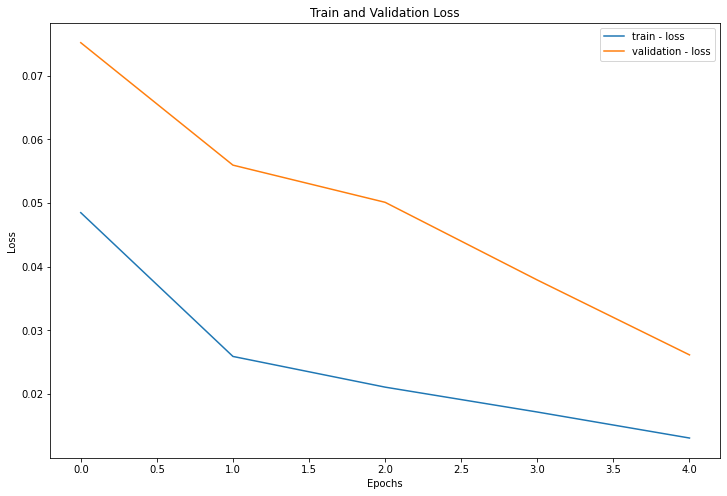

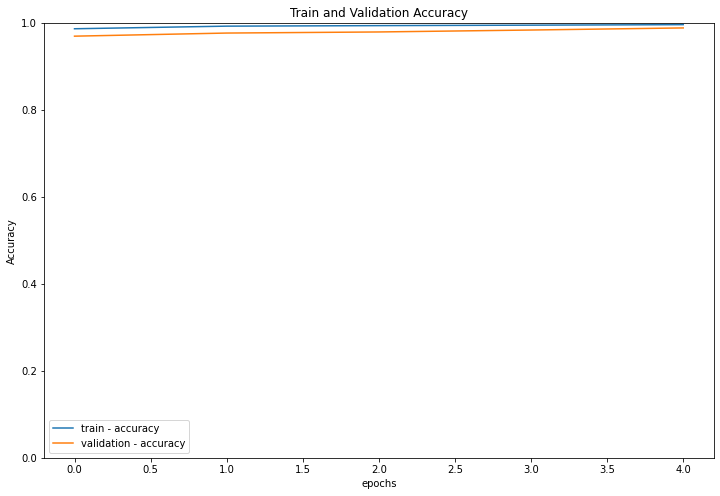

In [9]:
fig = plt.figure(figsize=(12, 8))
plt.plot(training_loss, label='train - loss')
plt.plot(validation_loss, label='validation - loss')
plt.title("Train and Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")
plt.show()

fig = plt.figure(figsize=(12, 8))
plt.plot(training_accuracy, label='train - accuracy')
plt.plot(validation_accuracy, label='validation - accuracy')
plt.title("Train and Validation Accuracy")
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend(loc="best")
plt.show()

### Plot confusion matrix

In [10]:
from sklearn.metrics import classification_report

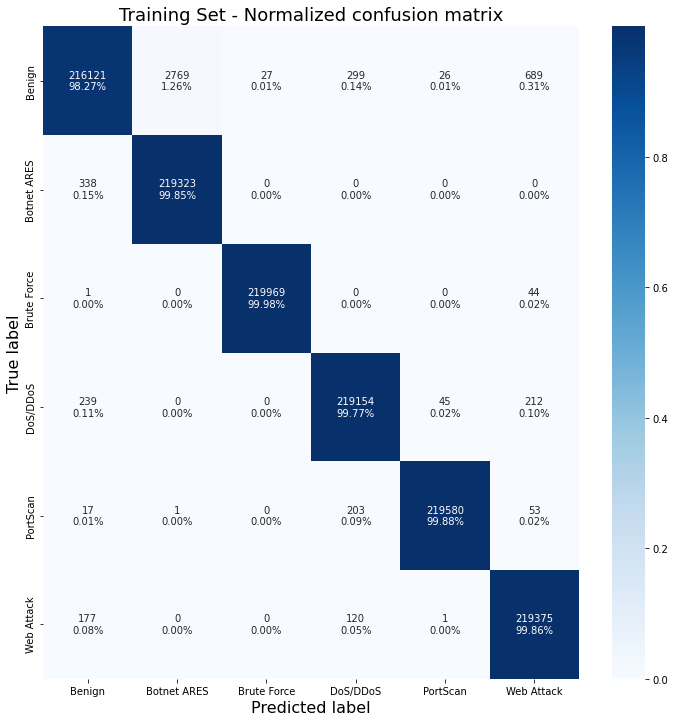

In [11]:
labels = ['Benign', 'Botnet ARES', 'Brute Force', 'DoS/DDoS', 'PortScan', 'Web Attack']

utils.plot_confusion_matrix(y_true=train_output_true,
                            y_pred=train_output_pred,
                            labels=labels,
                            title="Training Set - Normalized confusion matrix",
                            save=True,
                            filename="wrs_nn_train_confusion_matrix.png")

In [12]:
print("Training Set -- Classification Report", end="\n\n")
print(classification_report(train_output_true, train_output_pred, target_names=labels))

Training Set -- Classification Report

              precision    recall  f1-score   support

      Benign       1.00      0.98      0.99    219931
 Botnet ARES       0.99      1.00      0.99    219661
 Brute Force       1.00      1.00      1.00    220014
    DoS/DDoS       1.00      1.00      1.00    219650
    PortScan       1.00      1.00      1.00    219854
  Web Attack       1.00      1.00      1.00    219673

    accuracy                           1.00   1318783
   macro avg       1.00      1.00      1.00   1318783
weighted avg       1.00      1.00      1.00   1318783



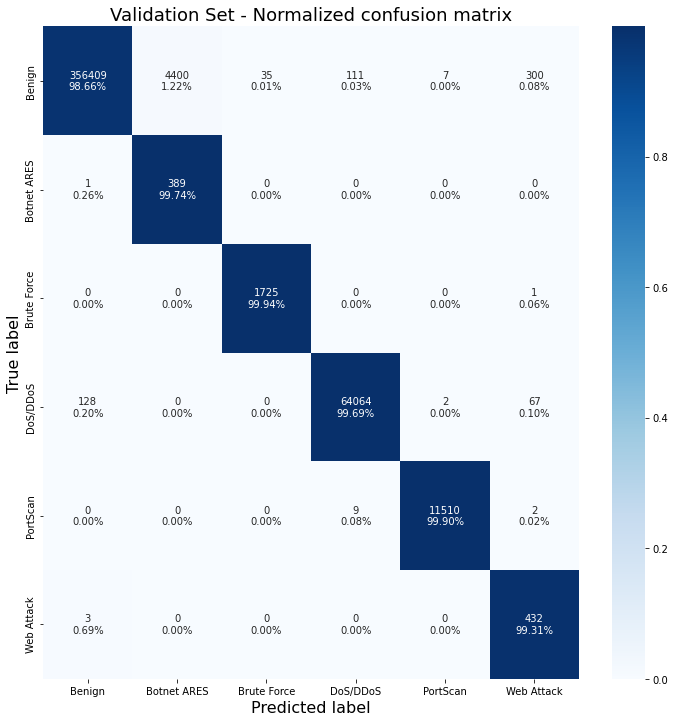

In [13]:
utils.plot_confusion_matrix(y_true=valid_output_true,
                            y_pred=valid_output_pred,
                            labels=labels,
                            title="Validation Set - Normalized confusion matrix",
                            save=True,
                            filename="wrs_nn_valid_confusion_matrix.png")

In [14]:
print("Validation Set -- Classification Report", end="\n\n")
print(classification_report(valid_output_true, valid_output_pred, target_names=labels))

Validation Set -- Classification Report

              precision    recall  f1-score   support

      Benign       1.00      0.99      0.99    361262
 Botnet ARES       0.08      1.00      0.15       390
 Brute Force       0.98      1.00      0.99      1726
    DoS/DDoS       1.00      1.00      1.00     64261
    PortScan       1.00      1.00      1.00     11521
  Web Attack       0.54      0.99      0.70       435

    accuracy                           0.99    439595
   macro avg       0.77      1.00      0.80    439595
weighted avg       1.00      0.99      0.99    439595



### Test it

In [15]:
def test(net, criterion, test_loader, device='cpu'):
    """Validate the network on the entire test set."""

    net.eval()

    history = {
        'test': {
            'total': 0,
            'loss': 0.0,
            'accuracy': 0.0,
            'output_pred': [],
            'output_pred_prob': []
        }
    }

    criterion = torch.nn.CrossEntropyLoss()

    test_loss = 0.0
    test_steps = 0
    test_total = 0
    test_correct = 0

    test_output_pred = []
    test_output_pred_prob = []

    with torch.no_grad():
        for (images, labels) in tqdm(test_loader):
            images, labels = images.to(device), labels.to(device)

            outputs = net(images.float())
            loss = criterion(outputs, labels.type(torch.LongTensor))

            test_loss += loss.cpu().item()
            test_steps += 1

            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels.type(torch.LongTensor)).sum().item()

            test_output_pred += outputs.argmax(1).cpu().tolist()
            test_output_pred_prob += nn.functional.softmax(
                outputs, dim=0).cpu().tolist()

    history['test']['total'] = test_total
    history['test']['loss'] = test_loss/test_steps
    history['test']['accuracy'] = test_correct/test_total
    history['test']['output_pred'].extend(test_output_pred)
    history['test']['output_pred_prob'].extend(test_output_pred_prob)

    print(f'Test loss: {test_loss/test_steps}, Test accuracy: {test_correct/test_total}')
    return history

In [16]:
#################
### TEST LOOP ###
#################
history = test(model, criterion, test_loader)

test_output_pred = history['test']['output_pred']
test_output_pred_prob = history['test']['output_pred_prob']

100%|██████████████████████████████████████████████████████████████████████████████| 6869/6869 [02:21<00:00, 48.65it/s]

Test loss: 0.025933644579309856, Test accuracy: 0.9884211603862646


### Classification Report

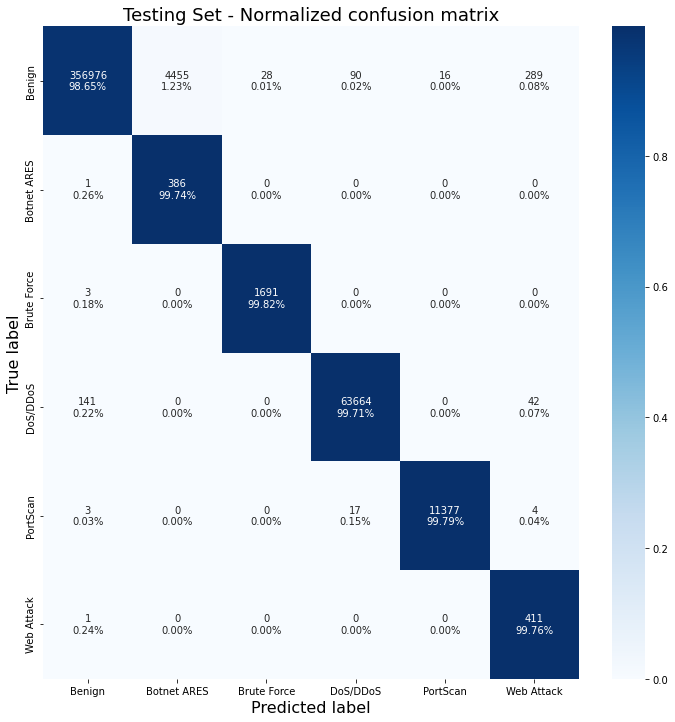

In [17]:
utils.plot_confusion_matrix(y_true=test_data.labels['label'].tolist(),
                            y_pred=test_output_pred,
                            labels=labels,
                            title="Testing Set - Normalized confusion matrix",
                            save=True,
                            filename="wrs_nn_test_confusion_matrix.png")

In [18]:
print("Testing Set -- Classification Report", end="\n\n")
print(classification_report(test_data.labels['label'].tolist(), test_output_pred, target_names=labels))

Testing Set -- Classification Report

              precision    recall  f1-score   support

      Benign       1.00      0.99      0.99    361854
 Botnet ARES       0.08      1.00      0.15       387
 Brute Force       0.98      1.00      0.99      1694
    DoS/DDoS       1.00      1.00      1.00     63847
    PortScan       1.00      1.00      1.00     11401
  Web Attack       0.55      1.00      0.71       412

    accuracy                           0.99    439595
   macro avg       0.77      1.00      0.81    439595
weighted avg       1.00      0.99      0.99    439595



### Plot ROC curve

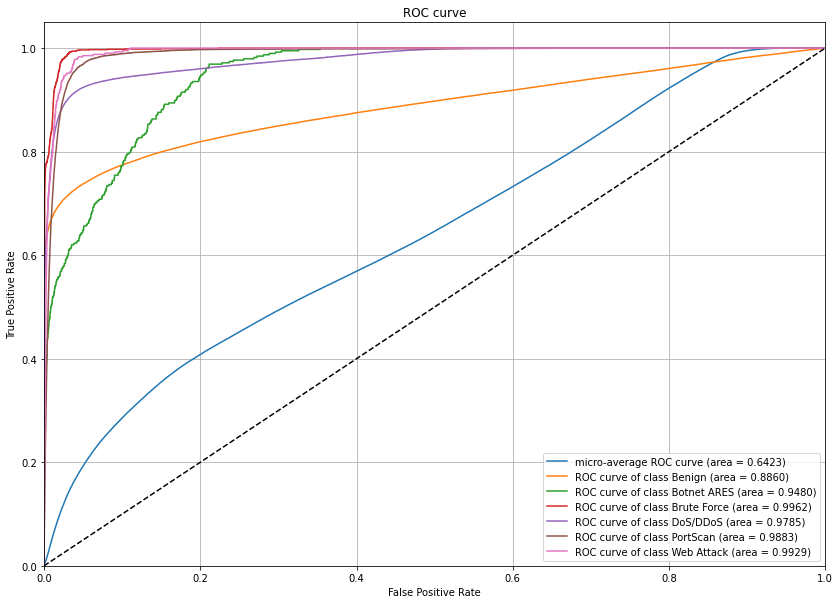

In [19]:
y_test = test_data.labels['label'].tolist()
y_test = pd.get_dummies(y_test).values
y_score = np.array(test_output_pred_prob)

utils.plot_roc_curve(y_test=y_test,
               y_score=y_score,
               labels=labels,
               save=True,
               filename="wrs_nn_roc_curve.png")

### Plot precision vs. recall curve

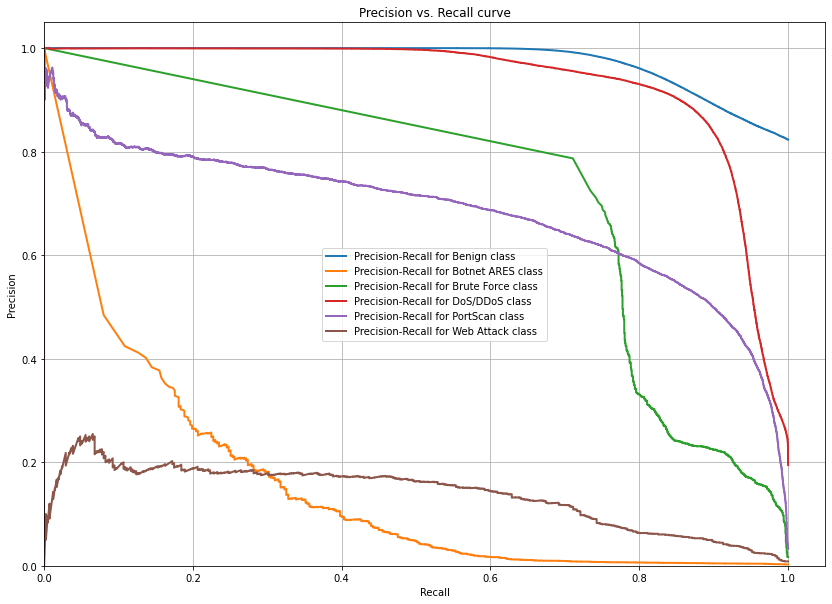

In [20]:
utils.plot_precision_recall_curve(y_test,
                                  y_score,
                                  labels=labels,
                                  save=True,
                                  filename="wrs_nn_prec_recall_curve.png")

In [21]:
path = '../checkpoints/wrs_neural_network.pt'
torch.save({
            'epoch': num_epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, path)